In [7]:
%load_ext autoreload
%autoreload 2

#from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScaledScore_fSin_T256_H05_tl_5data import get_config as get_config
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_5data import get_config as get_config
#from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config as get_config
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_5data_Small import get_config as get_config

from configs import project_config
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching  import \
    ConditionalMarkovianTSPostMeanScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSScoreMatching  import \
    ConditionalMarkovianTSScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 1440#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss
if "PM" in config.scoreNet_trained_path:
    PM = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters).to(device)
else:
    PM = ConditionalMarkovianTSScoreMatching(*config.model_parameters).to(device)
PM.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))

0.0
Using CPU



<All keys matched successfully>

In [14]:
Ndiff = config.max_diff_steps
print(Ndiff)
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = ""
file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_Small_mkv_ES40_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
Xs = torch.Tensor(np.linspace(-3,3,256))#np.load(file_path+"numpyXs.npy"))
if type == "":
    type="Standard"
print(type)

10000
PM


In [15]:
def plot_drift_estimator(mean, stds, numpy_Xs, type, toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = np.power(np.mean(np.power(np.sin(numpy_Xs) - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, np.sin(numpy_Xs), color="red", label="True Drift")

    ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Drift Estimator with 2 Std")
    ax.set_title(rf"RMSE {round(rmse,3)} of estimator $\bar{{\mu}}(x)$", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $x$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(loc="lower right", fontsize=25)
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fSin_{type}.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [16]:
print(type,muhats.shape)
assert (config.max_diff_steps == 10000)

PM torch.Size([256, 10000, 5])


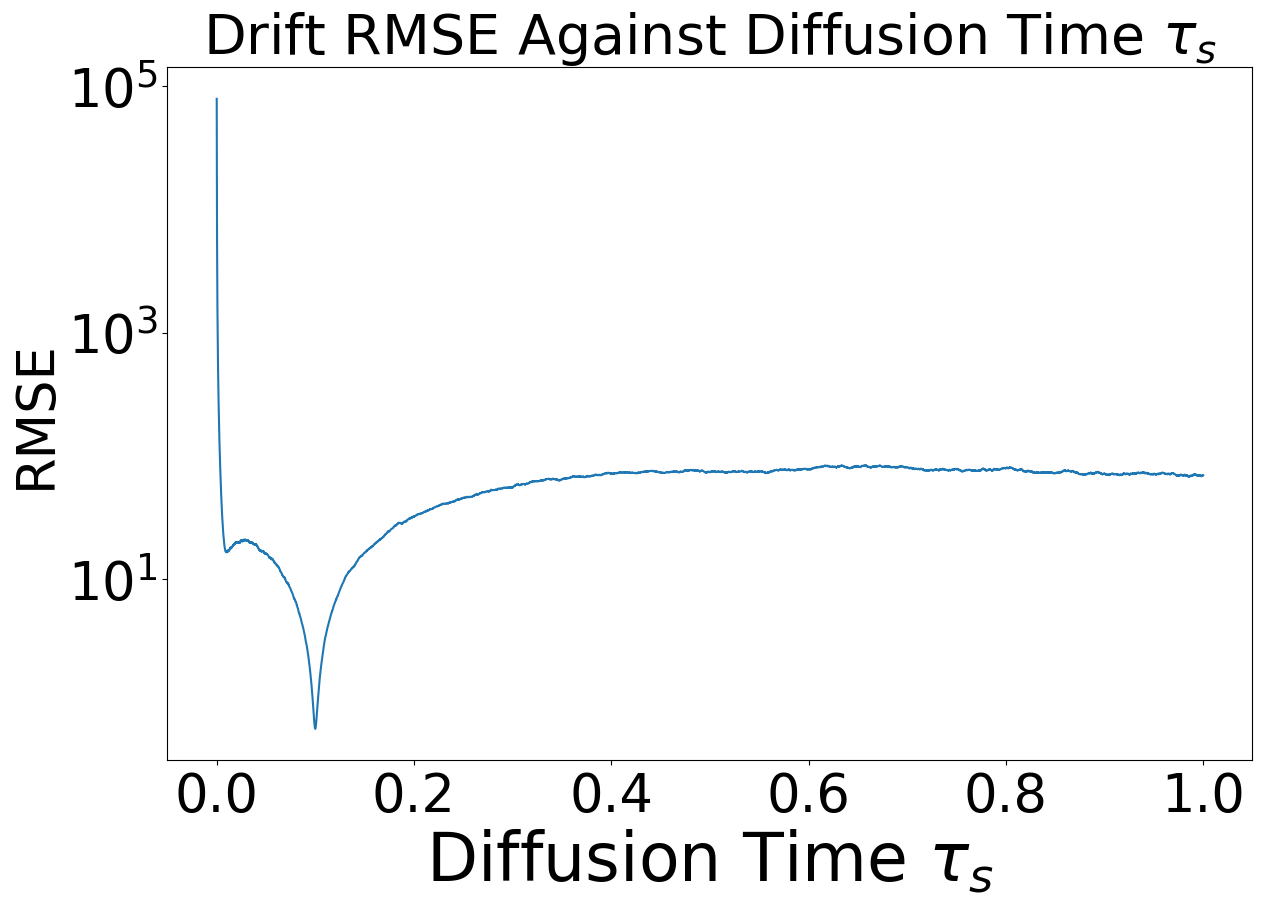

In [17]:
true_drifts = np.sin(Xs).unsqueeze(-1)
diff_mses = (true_drifts - muhats.mean(dim=-1).numpy()).permute(1,0).pow(2).sum(dim=-1) / (muhats.shape[0])
diff_rmses = diff_mses.pow(0.5)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(np.linspace(config.sample_eps, config.end_diff_time, muhats.shape[1]), diff_rmses)
ax.set_title(r"Drift RMSE Against Diffusion Time $\tau_{s}$", fontsize=40)
ax.tick_params(labelsize=38)
plt.yscale("log")
ax.set_xlabel(r"Diffusion Time $\tau_{s}$", fontsize=48)
ax.set_ylabel(r"RMSE", fontsize=38)
plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fSin_{type}_RMSEs.png",  bbox_inches='tight')

In [ ]:
mu_hats = muhats[:, -100, :].reshape(muhats.shape[0], muhats.shape[-1]).mean(dim=-1).numpy()
stds = muhats[:, -100, :].reshape(muhats.shape[0], muhats.shape[-1]).std(dim=-1).numpy()
plot_drift_estimator(mean=mu_hats, stds=0*stds, numpy_Xs=Xs.numpy(), type=type, toSave=True)
print(np.mean(stds))

In [ ]:
print(diff_rmses.min())

In [ ]:
mu_hats = muhats.mean(dim=-1).numpy()
per_diff_stds = muhats.std(dim=-1).numpy()

In [ ]:
for j in range(0, 50, -1):
    plot_drift_estimator(mean=mu_hats[:,j], stds=per_diff_stds[:, j], numpy_Xs=Xs.numpy(), type="type", toSave=False)

In [ ]:
start_diff_idx = int(muhats.shape[1]*0.01)
end_diff_idx = int(muhats.shape[1]*1)
print(end_diff_idx)
mu_hats = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).mean(dim=-1).numpy()
stds = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).std(dim=-1).numpy()

In [ ]:
plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=Xs.numpy(), type=type, toSave=True)
print(np.mean(stds))